### Visualizing the distribution of the observations

### Load the required libraries

In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math
%pylab inline

import findspark
findspark.init()

from pyspark import SparkContext
#sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

import sys
sys.path.append('./lib')

import numpy as np
from numpy_pack import packArray,unpackArray
from spark_PCA import computeCov
from computeStats import computeOverAllDist, STAT_Descriptions

### Read the data frame from pickle file

data_dir='../../Data/Weather'
file_index='SBBSSBSS'

from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
print 'keys from STAT=',STAT.keys()

#read data
filename=data_dir+'/US_Weather_%s.parquet'%file_index

df=sqlContext.read.parquet(filename)
print df.count()
df.show(5)

Populating the interactive namespace from numpy and matplotlib
keys from STAT= ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']
12473
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|   1943.1| 41.5833|-109.2167|       TMAX|USC00487840|     4|[40 CC 80 4D 80 4...|1933.0|SBBSSBSS|
|   1943.1| 41.5833|-109.2167|       TMAX|USC00487840|     0|[30 54 A0 53 80 5...|1934.0|SBBSSBSS|
|   1943.1| 41.5833|-109.2167|       TMAX|USC00487840|     1|[40 CC 00 4F 00 0...|1935.0|SBBSSBSS|
|   1943.1| 41.5833|-109.2167|       TMAX|USC00487840|     1|[40 CC 80 4D 40 C...|1936.0|SBBSSBSS|
|   1943.1| 41.5833|-109.2167|       TMAX|USC00487840|     5|[30 D4 E0 D5 30 D...|1937.0|SBBSSBSS|
+---------+--------+---------+-----------+-----------+------+-------------

### Select data for a particular station and measurement type

In [2]:
sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT * FROM weather\n\tWHERE measurement='%s' and station='%s'"%('TMIN','USW00024057')
print Query
df1 = sqlContext.sql(Query)
print df1.count(),'rows'
df1.show(2)
rows=df1.rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect()
T=np.vstack(rows)
T=T/10.  # scaling to make the temperature be in centingrates
shape(T)

SELECT * FROM weather
	WHERE measurement='TMIN' and station='USW00024057'
61 rows
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|   2053.1| 41.8056|-107.1997|       TMIN|USW00024057|     5|[40 DA C8 DA 00 7...|1952.0|SBBSSBSS|
|   2053.1| 41.8056|-107.1997|       TMIN|USW00024057|     0|[F0 D6 80 D8 A0 D...|1953.0|SBBSSBSS|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 2 rows



(61, 365)

In [3]:
from YearPlotter import YearPlotter
YP=YearPlotter()

(365,)
(365,)
(365,)


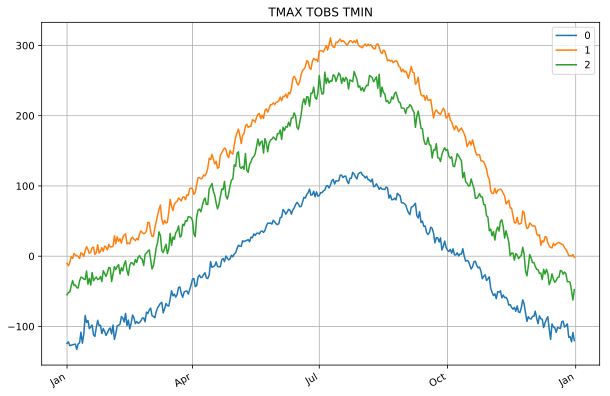

In [5]:
r = []
rows = sqlContext.sql("SELECT * FROM weather WHERE measurement='TMIN' and station='USC00487840'").rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect()
print nanmean(rows, axis=0).shape
r.append(nanmean(rows, axis=0))
rows = sqlContext.sql("SELECT * FROM weather WHERE measurement='TMAX' and station='USC00487840'").rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect()
print nanmean(rows, axis=0).shape
r.append(nanmean(rows, axis=0))
rows = sqlContext.sql("SELECT * FROM weather WHERE measurement='TOBS' and station='USC00487840'").rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect()
print nanmean(rows, axis=0).shape
r.append(nanmean(rows, axis=0))

fig, ax = plt.subplots(figsize=(10,7));
YP=YearPlotter()
YP.plot(vstack(r).T,fig,ax,title='TMAX TOBS TMIN')

### Script for plotting yearly plots

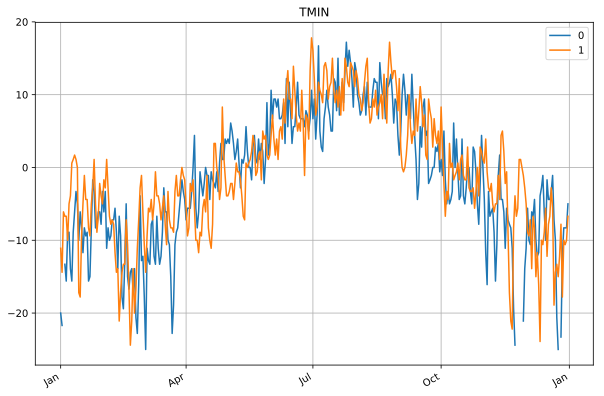

In [6]:
from YearPlotter import YearPlotter
fig, ax = plt.subplots(figsize=(10,7));
YP=YearPlotter()
YP.plot(T[:2,:].transpose(),fig,ax,title='TMIN')
#title('A sample of graphs');

### Distribution of missing observations
The distribution of missing observations is not uniform throughout the year. We visualize it below.

In [7]:
def plot_pair(pair,func):
    j=0
    fig,X=subplots(1,2,figsize=(12,4))
    axes=X.reshape(2)
    for m in pair:
        axis = axes[j]
        j+=1
        func(m,fig,axis)
        
def plot_valid(m,fig,axis):
    valid_m=STAT[m]['NE']
    YP.plot(valid_m,fig,axis,title='valid-counts '+m)
    

/usr/local/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


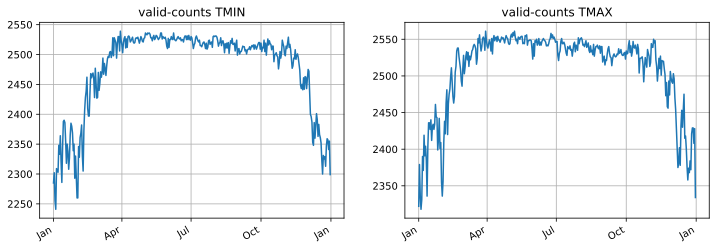

In [8]:
plot_pair(['TMIN','TMAX'],plot_valid)

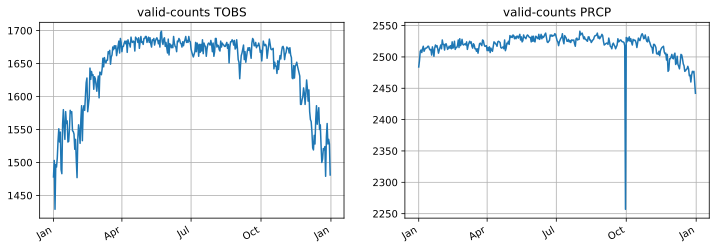

In [9]:
plot_pair(['TOBS','PRCP'],plot_valid)

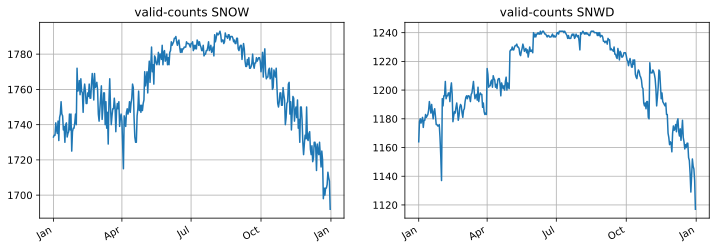

In [10]:
plot_pair(['SNOW', 'SNWD'],plot_valid)

### Plots of mean and std of observations

In [13]:
def plot_mean_std(m,fig,axis):
    mean=STAT[m]['Mean']
    std=np.sqrt(STAT[m]['Var'])
    graphs=np.vstack([mean-std,mean,mean+std]).transpose()
    YP.plot(graphs,fig,axis,title='Mean+-std   '+m)

In [11]:
for m in ['TMAX', 'TMIN', 'PRCP']:
    Query="SELECT * FROM weather WHERE measurement='%s' and station='%s'"%(m,'USW00024057')
    print Query
    df1 = sqlContext.sql(Query)
    print df1.count(),'rows'
    if m == 'PRCP':
        rows=df1.rdd.map(lambda row:unpackArray(row['vector'],np.float16)/10/3*3.55)
    else:
        rows=df1.rdd.map(lambda row:unpackArray(row['vector'],np.float16)/10*1.8+32)
    STAT[m + ' of USW00024057'] = computeOverAllDist(rows)
    STAT[m + ' of USW00024057'].update(computeCov(rows))

SELECT * FROM weather WHERE measurement='TMAX' and station='USW00024057'
61 rows
shape of E= (365,) shape of NE= (365,)
SELECT * FROM weather WHERE measurement='TMIN' and station='USW00024057'
61 rows
shape of E= (365,) shape of NE= (365,)
SELECT * FROM weather WHERE measurement='PRCP' and station='USW00024057'
61 rows
shape of E= (365,) shape of NE= (365,)


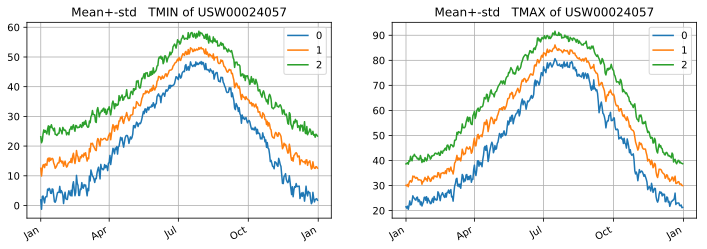

In [14]:
plot_pair(['TMIN of USW00024057','TMAX of USW00024057'],plot_mean_std)
savefig('r_figures/TMIN,TMAX_USW00024057.svg')

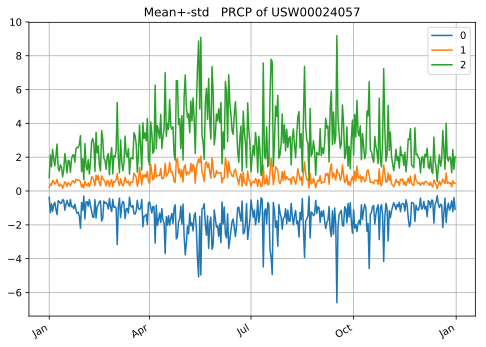

In [15]:
fig, ax = plt.subplots(figsize=(8, 6))
plot_mean_std('PRCP of USW00024057', fig, ax)
savefig('r_figures/PRCP_USW00024057.svg')

In [16]:
STAT['PRCP of USW00024057']['mean']

0.75351606184740705

In [17]:
plot_pair(['TMIN','TMAX'],plot_mean_std)

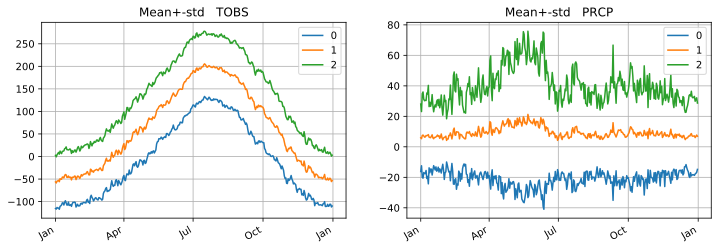

In [18]:
plot_pair(['TOBS','PRCP'],plot_mean_std)

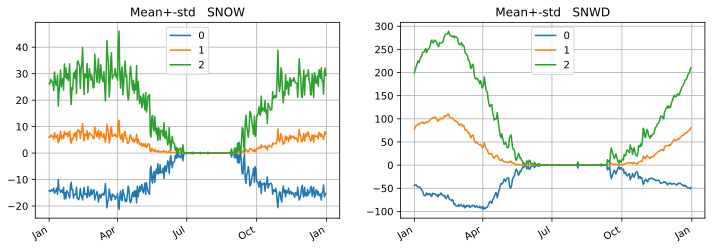

In [19]:
plot_pair(['SNOW', 'SNWD'],plot_mean_std)

### plotting top 3 eigenvectors

In [20]:
def plot_eigen(m,fig,axis):
    EV=STAT[m]['eigvec']
    YP.plot(EV[:,:3],fig,axis,title='Top Eigenvectors '+m)

In [ ]:
plot_pair(['TMIN','TMAX'],plot_eigen)

In [ ]:
plot_pair(['TOBS','PRCP'],plot_eigen)

In [ ]:
plot_pair(['SNOW', 'SNWD'],plot_eigen)

### Script for plotting percentage of variance explained

In [21]:
def pltVarExplained(j):
    subplot(1,3,j)
    EV=STAT[m]['eigval']
    k=5
    plot(([0,]+list(cumsum(EV[:k])))/sum(EV))
    title('Percentage of Variance Explained for '+ m)
    ylabel('Percentage of Variance')
    xlabel('# Eigenvector')
    grid()
    

In [22]:
for m in ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']:
    print m, cumsum(STAT[m]['eigval'][:5]) / sum(STAT[m]['eigval'])

TMIN [ 0.20510386  0.22973621  0.25124375  0.27194704  0.29198903]
TOBS [ 0.44787996  0.46869527  0.48560753  0.50025784  0.51404707]
TMAX [ 0.20840877  0.24271757  0.27261944  0.2983165   0.32226709]
SNOW [ 0.02749857  0.04447921  0.06071461  0.07547168  0.08996214]
SNWD [ 0.65785789  0.73034634  0.7937187   0.82454116  0.84409192]
PRCP [ 0.04362342  0.06182099  0.0790048   0.09579194  0.11077947]


In [23]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['TMIN', 'TOBS', 'TMAX']: #,
    pltVarExplained(j)
    j+=1

In [ ]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['SNOW', 'SNWD', 'PRCP']:
    pltVarExplained(j)
    j+=1 

---

In [23]:
from numpy import linalg as LA

def conv(a, i):
    r = copy(a)
    for _ in range(i):
        a = hstack((a[1:], a[:1]))
        r += a
    return hstack((r[-i/2:], r[:-i/2])) / (i + 1)

In [4]:
df = sqlContext.sql("SELECT * FROM weather WHERE measurement = 'PRCP'")
rdd = df.rdd.map(lambda row: unpackArray(row['vector'],np.float16)).cache()

In [19]:
def c():
    subplots(figsize=(10, 6))
    r = range(0, 60, 10)
    for i in r:
        data = rdd.map(lambda row: conv(row, i))
        OUT=computeCov(data)
        eigval,eigvec=LA.eig(OUT['Cov'])
        EV = eigval
        plot(([0,]+list(cumsum(EV[:5])))/sum(EV))
    legend(['Conv = {}'.format(i) for i in r])
    title('Percentage of Variance Explained for PRCP')
    ylabel('Percentage of Variance')
    xlabel('# Eigenvector')
    grid()

c()
savefig('r_figures/PRCP_Conv_VarExplained.svg')

shape of E= (365,) shape of NE= (365,)
shape of E= (365,) shape of NE= (365,)
shape of E= (365,) shape of NE= (365,)
shape of E= (365,) shape of NE= (365,)
shape of E= (365,) shape of NE= (365,)
shape of E= (365,) shape of NE= (365,)


In [10]:
row = sqlContext.sql('select vector from weather where measurement = "PRCP" limit 1').rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect()[0]

In [28]:
r = []
Legends = []
for i in range(10, 50, 10):
    r.append(conv(row, i))
    Legends.append('conv = {}'.format(i))
fig, ax = plt.subplots(figsize=(10,7));
YP.plot(array(r).transpose(),fig,ax)
ax.legend(Legends)
savefig('r_figures/PRCP_Conv.svg')